In [1]:
#Imports

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Load Data

admissions = pd.read_csv("admissions.csv", parse_dates=["admittime", "dischtime"])
patients = pd.read_csv("patients.csv")
diagnoses = pd.read_csv("diagnoses_icd.csv")
d_icd_diag = pd.read_csv("d_icd_diagnoses.csv")
procedures = pd.read_csv("procedures_icd.csv")
transfers = pd.read_csv("transfers.csv")

In [3]:
# ICD Label Prep

diagnoses = diagnoses.merge(d_icd_diag, on=['icd_code', 'icd_version'], how='left')
diagnoses = diagnoses[diagnoses['icd_version'] == 10]
diagnoses['icd_block'] = diagnoses['icd_code'].str[:3]

top_blocks = diagnoses['icd_block'].value_counts().head(20).index.tolist()
diagnoses_filtered = diagnoses[diagnoses['icd_block'].isin(top_blocks)]

icd_multilabel = (
    diagnoses_filtered
    .groupby('hadm_id')['icd_block']
    .apply(list)
    .reset_index()
)

mlb = MultiLabelBinarizer()
icd_multihot = pd.DataFrame(
    mlb.fit_transform(icd_multilabel['icd_block']),
    columns=mlb.classes_,
    index=icd_multilabel['hadm_id']
).reset_index()

In [4]:
#Feature Engineering

admissions = admissions.merge(patients[['subject_id', 'gender']], on='subject_id', how='left')
if 'anchor_age' in patients.columns:
    admissions = admissions.merge(patients[['subject_id', 'anchor_age']], on='subject_id', how='left')
    admissions.rename(columns={"anchor_age": "age"}, inplace=True)

admissions['los'] = (admissions['dischtime'] - admissions['admittime']).dt.days
admissions = pd.get_dummies(admissions, columns=['admission_type', 'insurance', 'gender'], drop_first=True)

n_diag = diagnoses.groupby('hadm_id')['icd_code'].count().reset_index(name='n_diagnoses')
admissions = admissions.merge(n_diag, on='hadm_id', how='left')

n_proc = procedures.groupby('hadm_id')['icd_code'].count().reset_index(name='n_procedures')
admissions = admissions.merge(n_proc, on='hadm_id', how='left')

icu = transfers[transfers['careunit'].str.contains("ICU", na=False)]
icu_flag = icu.groupby('hadm_id').size().reset_index(name='icu_flag')
icu_flag['icu_flag'] = 1
admissions = admissions.merge(icu_flag[['hadm_id', 'icu_flag']], on='hadm_id', how='left')
admissions['icu_flag'] = admissions['icu_flag'].fillna(0)

admissions['n_diagnoses'].fillna(0, inplace=True)
admissions['n_procedures'].fillna(0, inplace=True)
admissions = admissions.sort_values(by=["subject_id", "admittime"])
admissions['num_prev_admissions'] = admissions.groupby("subject_id").cumcount()

features = ['age', 'los', 'n_diagnoses', 'n_procedures', 'icu_flag', 'num_prev_admissions'] + \
    [col for col in admissions.columns if col.startswith(("admission_type_", "insurance_", "gender_"))]

feature_df = admissions[["hadm_id"] + features]

/var/folders/zr/3d272zpd4vv3hvlhrp34nnyr0000gn/T/ipykernel_88343/3200271347.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  admissions['n_diagnoses'].fillna(0, inplace=True)
/var/folders/zr/3d272zpd4vv3hvlhrp34nnyr0000gn/T/ipykernel_88343/3200271347.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [5]:
diagnoses = diagnoses.merge(d_icd_diag, on=['icd_code', 'icd_version'], how='left')
diagnoses = diagnoses[diagnoses['icd_version'] == 10]
diagnoses['icd_block'] = diagnoses['icd_code'].str[:3]
diagnoses['icd_chapter'] = diagnoses['icd_code'].str[0]  # 'E', 'I', etc.

# ---- Chapter Labels ----
chapter_labels = diagnoses.groupby('hadm_id')['icd_chapter'].apply(lambda x: list(set(x))).reset_index()
mlb_chapter = MultiLabelBinarizer()
y_chapters = pd.DataFrame(
    mlb_chapter.fit_transform(chapter_labels['icd_chapter']),
    columns=mlb_chapter.classes_,
    index=chapter_labels['hadm_id']
).reset_index()

# ---- Block Labels (top 20 blocks) ----
top_blocks = diagnoses['icd_block'].value_counts().head(20).index.tolist()
block_filtered = diagnoses[diagnoses['icd_block'].isin(top_blocks)]
block_labels = block_filtered.groupby('hadm_id')['icd_block'].apply(list).reset_index()
mlb_block = MultiLabelBinarizer()
y_blocks = pd.DataFrame(
    mlb_block.fit_transform(block_labels['icd_block']),
    columns=mlb_block.classes_,
    index=block_labels['hadm_id']
).reset_index()

In [6]:
df_chapters = feature_df.merge(y_chapters, on="hadm_id", how="inner")
df_blocks = feature_df.merge(y_blocks, on="hadm_id", how="inner")

X_chapters = df_chapters[features]
y_chapters = df_chapters[mlb_chapter.classes_]

X_blocks = df_blocks[features]
y_blocks = df_blocks[mlb_block.classes_]

In [7]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_chapters, y_chapters, test_size=0.2, random_state=42)
clf_chapter = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42))
clf_chapter.fit(Xc_train, yc_train)

# Block Model
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_blocks, y_blocks, test_size=0.2, random_state=42)
clf_block = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42))
clf_block.fit(Xb_train, yb_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       random_state=42))

In [8]:
# Evaluate Chapter Model

y_pred_chap = clf_chapter.predict(Xc_test)

print("Classification Report — ICD Chapters (Multi-label):")
print(classification_report(yc_test, y_pred_chap, target_names=mlb_chapter.classes_))

# Evaluate Block Model
y_pred_block = clf_block.predict(Xb_test)

print("Classification Report — ICD Blocks (Multi-label):")
print(classification_report(yb_test, y_pred_block, target_names=mlb_block.classes_))

📊 Classification Report — ICD Chapters (Multi-label):
              precision    recall  f1-score   support

           A       0.19      0.72      0.30      2367
           B       0.29      0.70      0.41      4711
           C       0.25      0.77      0.38      4512
           D       0.60      0.75      0.67     11397
           E       0.86      0.81      0.83     20184
           F       0.64      0.67      0.65     14459
           G       0.52      0.72      0.61     11307
           H       0.16      0.66      0.25      2616
           I       0.88      0.84      0.86     20553
           J       0.48      0.68      0.57      9323
           K       0.61      0.72      0.66     13896
           L       0.21      0.59      0.32      3501
           M       0.45      0.72      0.56      9530
           N       0.63      0.74      0.68     11325
           O       0.52      0.96      0.67      1389
           P       1.00      0.67      0.80         6
           Q       0.05    

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


📊 Classification Report — ICD Blocks (Multi-label):
              precision    recall  f1-score   support

         E11       0.39      0.75      0.51      7083
         E78       0.56      0.80      0.66     11112
         E87       0.39      0.73      0.51      5238
         F32       0.33      0.61      0.43      5816
         F41       0.30      0.63      0.40      5004
         G47       0.24      0.69      0.36      4207
         I10       0.50      0.74      0.59     10400
         I25       0.41      0.76      0.53      6122
         I48       0.36      0.77      0.49      5015
         I50       0.39      0.79      0.52      5012
         K21       0.35      0.67      0.46      6822
         N17       0.36      0.78      0.49      4591
         N18       0.37      0.77      0.50      4963
         Y92       0.46      0.58      0.52      8116
         Z68       0.32      0.75      0.45      4959
         Z79       0.52      0.72      0.60      9251
         Z85       0.26      

/Users/rohitkulkarni/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


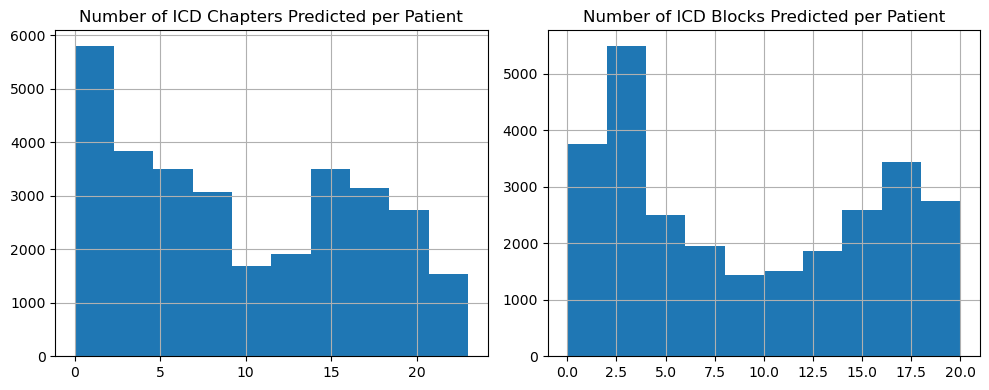

In [9]:
num_chapter_preds = pd.DataFrame(y_pred_chap, columns=mlb_chapter.classes_).sum(axis=1)
num_block_preds = pd.DataFrame(y_pred_block, columns=mlb_block.classes_).sum(axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
num_chapter_preds.hist()
plt.title("Number of ICD Chapters Predicted per Patient")

plt.subplot(1, 2, 2)
num_block_preds.hist()
plt.title("Number of ICD Blocks Predicted per Patient")

plt.tight_layout()
plt.show()

In [11]:
import joblib
import os

# Create model folder
os.makedirs("models", exist_ok=True)

# Save Chapter model
joblib.dump(clf_chapter, "models/icd_chapter_model.pkl")

# Save Block model
joblib.dump(clf_block, "models/icd_block_model.pkl")

# Save label names (column order matters for multi-output)
joblib.dump(y_chapters.columns.tolist(), "models/icd_chapter_labels.pkl")
joblib.dump(y_blocks.columns.tolist(), "models/icd_block_labels.pkl")

# Save feature list used by both models
joblib.dump(X_chapters.columns.tolist(), "models/icd_model_features.pkl")

['models/icd_model_features.pkl']